In [1]:
#!pip3 -qq install torch==0.4.1
# !pip install torchtext==0.3.1
# !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1Pq4aklVdj-sOnQw68e1ZZ_ImMiC8IR1V' -O tweets.csv.zip
# !wget --no-check-certificate "https://drive.google.com/uc?export=download&id=1ji7dhr9FojPeV51dDlKRERIqr3vdZfhu" -O surnames.txt
# !unzip tweets.csv.zip

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
    DEVICE = torch.device('cuda')
else:
    from torch import FloatTensor, LongTensor
    DEVICE = torch.device('cpu')

np.random.seed(42)

# Языковые модели

*Языковая модель* - это штука, которая умеет оценивать вероятности встретить последовательность слов $w_1, \ldots, w_n$:   
$$\mathbf{P}(w_1, \ldots, w_n) = \prod_k \mathbf{P}(w_k|w_{k-1}, \ldots, w_{1}).$$

Интерпретируемы и интересны тут именно условные вероятности - какое слово языковая модель ожидает вслед за данными. У нас у всех такая языковая модель есть, так-то. Например, в таком контексте

![](https://hsto.org/web/956/239/601/95623960157b4e15a1b3f599aed62ed2.png " ")

моя языковая модель говорит - после *честных* навряд ли пойдёт *мой*. А вот *и* или, конечно, *правил* - очень даже.

А задача такая: научиться генерировать политические твиты по образу и подобию `Russian Troll Tweets`. Датасет взят отсюда: https://www.kaggle.com/vikasg/russian-troll-tweets

In [3]:
import pandas as pd

data = pd.read_csv('tweets.csv')

data.text.sample(15).tolist()

['RT @RivalThoughts: @CNN This lack of forethought is what ran the country into the ground.',
 "#TopNews Icahn on CNBC:'Archie Bunker of the world' will vote for Trump",
 'RT @mclark1951: Just 5.7 Percent Of #Clinton Foundation Budget Actually Went To Charitable Grants https://t.co/c2EIYW4w9H #uniteblue2016 #p…',
 "RT @JamilSmith: Read @jelani9 on Rudy Giuliani's flailing effort to gain relevance in this Trump moment. https://t.co/48p9d31pgi",
 'RT @Laura_A_Diaz: #StandUpWithEvan #MakeHistoryWithEvan  Unite and #Vote3rdParty #Deny270 https://t.co/quB1FdZZAo',
 'RT @MommyExchangeGa: Camouflage Wedding Rings Made From Titanium! High Quality. Choose from Promise, Wedding, Friendship and Couples https:…',
 'RT @NewssTrump: BREAKING: Trump’s UN Ambassador Just Put The Fear Of God In Our Enemies! She Just Gave The UN Teeth For The First… https://…',
 '@Nero March for Trump at Trump tower NY happening now:\n#Trump #MAGA https://t.co/SWvbWxOEjO',
 "Why don't Portuguese Muslims speak out and co

In [4]:
data.head()

,user_id,user_key,created_at,created_str,retweet_count,retweeted,favorite_count,text,tweet_id,source,hashtags,expanded_urls,posted,mentions,retweeted_status_id,in_reply_to_status_id
0,1.868981e+09,ryanmaxwell_1,1.458672e+12,2016-03-22 18:31:42,NaN,NaN,NaN,#IslamKills Are you trying to say that there w...,7.123460e+17,NaN,"[""IslamKills""]",[],POSTED,[],NaN,NaN
1,2.571870e+09,detroitdailynew,1.476133e+12,2016-10-10 20:57:00,0.0,False,0.0,"Clinton: Trump should’ve apologized more, atta...",7.855849e+17,"<a href=""http://twitterfeed.com"" rel=""nofollow...",[],"[""http://detne.ws/2e172jF""]",POSTED,[],NaN,NaN
2,1.710805e+09,cookncooks,1.487767e+12,2017-02-22 12:43:43,NaN,NaN,NaN,RT @ltapoll: Who was/is the best president of ...,8.343832e+17,NaN,[],[],POSTED,[],NaN,NaN
3,2.584153e+09,queenofthewo,1.482765e+12,2016-12-26 15:06:41,NaN,NaN,NaN,RT @jww372: I don't have to guess your religio...,8.134006e+17,NaN,"[""ChristmasAftermath""]",[],POSTED,[],NaN,NaN
4,1.768260e+09,mrclydepratt,1.501987e+12,2017-08-06 02:36:24,NaN,NaN,NaN,RT @Shareblue: Pence and his lawyers decided w...,8.940243e+17,NaN,[],[],POSTED,[],NaN,NaN


Да, результаты будут упороты, сразу предупреждаю.

## Чтение данных

Кого-нибудь уже достало писать все эти построения батчей, словари - вот это всё? Лично меня - да!

В pytorch есть специальный класс для генерации батчей - `Dataset`. Вместо того, чтобы писать функцию типа `iterate_batches`, можно отнаследовать от него и переопределить методы `__len__` и `__getitem__`... и реализовать в них почти всё то, что было в `iterate_batches`. Пока не впечатляет, да?

Ещё там есть `DataLoader`, умеющий работать с датасетом. Он позволяет делать shuffle батчей и генерацию их в отдельных процессах - это особенно важно, когда генерация батча - долгая операция. Например, в картинках. Почитать про это всё можно здесь: [Data Loading and Processing Tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

Но пока что всё равно не особо круто, мне кажется. Интересно другое - у pytorch в репозитории живет отдельная библиотечка - [torchtext](https://github.com/pytorch/text). Вот она уже даст нам специальные реализации `Dataset` для работы с текстом и всякие тулзы, делающие жизнь чуточку проще.

Библиотеке, на мой взгляд, недостает туториалов, в которых бы показывалось, как с ней работать - но можно читать исходный код, он приятный.

План такой: построить класс `torchtext.data.Dataset`, для него создать итератор, и учить модель.

Данный датасет инициализируется двумя параметрами:
```
            examples: List of Examples.
            fields (List(tuple(str, Field))): The Fields to use in this tuple. The
                string is a field name, and the Field is the associated field.
```
Разберемся сначала со вторым.

`Field` - это такая мета-информация для датасета + обработчик сэмплов.  

Он имеет кучу параметров, на которые проще посмотреть [здесь](https://github.com/pytorch/text/blob/master/torchtext/data/field.py). Если коротко, то он может предобрабатывать (например, токенизировать) предложения, строить словарь (отображение из слова в индекс), строить батчи - добавлять паддинги и конвертировать в тензоры. Что ещё нужно в жизни?

Мы будем делать character-level языковую модель, поэтому токенизация для нас - превращение строки в набор символов. Попросим также добавлять в начало и конец спец-символы `<s>` и `</s>`.

In [5]:
from torchtext.data import Field

text_field = Field(init_token='<s>', eos_token='</s>', lower=True, tokenize=lambda line: list(line))

Препроцессинг будет выглядеть так:

In [6]:
text_field.preprocess(data.text.iloc[0])

['#',
 'i',
 's',
 'l',
 'a',
 'm',
 'k',
 'i',
 'l',
 'l',
 's',
 ' ',
 'a',
 'r',
 'e',
 ' ',
 'y',
 'o',
 'u',
 ' ',
 't',
 'r',
 'y',
 'i',
 'n',
 'g',
 ' ',
 't',
 'o',
 ' ',
 's',
 'a',
 'y',
 ' ',
 't',
 'h',
 'a',
 't',
 ' ',
 't',
 'h',
 'e',
 'r',
 'e',
 ' ',
 'w',
 'e',
 'r',
 'e',
 ' ',
 'n',
 'o',
 ' ',
 't',
 'e',
 'r',
 'r',
 'o',
 'r',
 'i',
 's',
 't',
 ' ',
 'a',
 't',
 't',
 'a',
 'c',
 'k',
 's',
 ' ',
 'i',
 'n',
 ' ',
 'e',
 'u',
 'r',
 'o',
 'p',
 'e',
 ' ',
 'b',
 'e',
 'f',
 'o',
 'r',
 'e',
 ' ',
 'r',
 'e',
 'f',
 'u',
 'g',
 'e',
 'e',
 's',
 ' ',
 'w',
 'e',
 'r',
 'e',
 ' ',
 'l',
 'e',
 't',
 ' ',
 'i',
 'n',
 '?']

Сконвертируем всё и посмотрим на распределение длин:

<a list of 30 Patch objects>

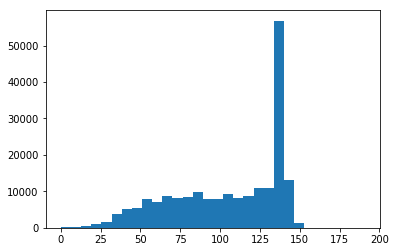

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

data['text'] = data['text'].fillna('')
lines = data.apply(lambda row: text_field.preprocess(row['text']), axis=1).tolist()

lengths = [len(line) for line in lines]

plt.hist(lengths, bins=30)[-1]

Отсечем слишком короткие строки и преобразуем оставшиеся в `Example`'ы:

In [8]:
from torchtext.data import Example

lines = [line for line in lines if len(line) >= 50]

fields = [('text', text_field)]
examples = [Example.fromlist([line], fields) for line in lines]

По `Example` можно получить обратно все поля, которые мы туда запихнули. Например, сейчас мы создали одно поле `text`:

In [9]:
examples[0].text

['#',
 'i',
 's',
 'l',
 'a',
 'm',
 'k',
 'i',
 'l',
 'l',
 's',
 ' ',
 'a',
 'r',
 'e',
 ' ',
 'y',
 'o',
 'u',
 ' ',
 't',
 'r',
 'y',
 'i',
 'n',
 'g',
 ' ',
 't',
 'o',
 ' ',
 's',
 'a',
 'y',
 ' ',
 't',
 'h',
 'a',
 't',
 ' ',
 't',
 'h',
 'e',
 'r',
 'e',
 ' ',
 'w',
 'e',
 'r',
 'e',
 ' ',
 'n',
 'o',
 ' ',
 't',
 'e',
 'r',
 'r',
 'o',
 'r',
 'i',
 's',
 't',
 ' ',
 'a',
 't',
 't',
 'a',
 'c',
 'k',
 's',
 ' ',
 'i',
 'n',
 ' ',
 'e',
 'u',
 'r',
 'o',
 'p',
 'e',
 ' ',
 'b',
 'e',
 'f',
 'o',
 'r',
 'e',
 ' ',
 'r',
 'e',
 'f',
 'u',
 'g',
 'e',
 'e',
 's',
 ' ',
 'w',
 'e',
 'r',
 'e',
 ' ',
 'l',
 'e',
 't',
 ' ',
 'i',
 'n',
 '?']

Построим, наконец, датасет:

In [10]:
from torchtext.data import Dataset

dataset = Dataset(examples, fields)

Датасет можно разбить на части:

In [11]:
train_dataset, test_dataset = dataset.split(split_ratio=0.75)

По нему можно построить словарь:

In [12]:
text_field.build_vocab(train_dataset, min_freq=30)

print('Vocab size =', len(text_field.vocab))
print(text_field.vocab.itos)

Vocab size = 308
['<unk>', '<pad>', '<s>', '</s>', ' ', 't', 'e', 'a', 'o', 'r', 'i', 's', 'n', 'l', 'h', 'c', 'p', 'd', 'm', 'u', '/', 'g', 'y', ':', 'w', 'b', 'f', '.', '@', 'k', 'v', '#', 'j', 'z', 'x', '\n', "'", '…', '1', ',', '0', '2', 'q', '\r', '!', '4', '6', '7', '3', '"', '5', '-', '9', '8', '_', '?', ';', '’', '&', ')', '(', '‘', '$', '“', '😂', '|', '*', '”', '%', '–', '️', 'о', '🇸', '🇺', 'а', 'ü', '\xa0', 'и', 'т', 'е', '▶', '🔥', 'н', '~', '+', 'ä', 'р', '[', ']', '💥', '—', 'л', 'с', '=', 'в', '🚨', 'é', 'к', 'м', '❤', 'п', 'д', 'ö', '👇', '👍', '🤔', 'ا', '‼', '😭', '👏', 'у', '★', '🏻', '`', '�', 'б', '🏾', 'з', '👉', '🙏', 'ы', 'ل', '😍', '🏼', '😡', 'г', 'ь', 'я', 'ß', '🏽', '»', '•', '✔', 'ч', '😊', 'ي', '🏿', 'й', 'م', '💯', '😎', '💀', '🙄', '😳', 'à', 'ر', 'х', 'و', '✨', 'ж', '➡', 'ن', '🙌', '💨', '✊', '👊', '«', '😉', 'è', '🌟', '⚡', '😘', 'ю', 'ा', 'ت', '💪', 'ш', '🎉', '😏', '🚂', '😩', 'د', '➠', '►', 'े', '💩', '💰', 'ب', '❗', 'ه', '👀', 'र', '😁', '👌', '😱', 'ع', '✅', '👈', 'क', '🌹', '´', '☺', '💣',

Наконец, по нему можно итерироваться:

In [13]:
from torchtext.data import BucketIterator

train_iter, test_iter = BucketIterator.splits(datasets=(train_dataset, test_dataset), batch_sizes=(32, 128), 
                                              shuffle=True, device=DEVICE, sort=False)

In [14]:
batch = next(iter(train_iter))

batch


[torchtext.data.batch.Batch of size 32]
	[.text]:[torch.cuda.LongTensor of size 150x32 (GPU 0)]

In [15]:
batch.text

tensor([[ 2,  2,  2,  ...,  2,  2,  2],
        [ 9, 31,  9,  ...,  9,  9, 17],
        [ 5, 12,  5,  ...,  5,  5,  8],
        ...,
        [ 1,  1,  1,  ...,  1,  1,  1],
        [ 1,  1,  1,  ...,  1,  1,  1],
        [ 1,  1,  1,  ...,  1,  1,  1]], device='cuda:0')

## Перплексия

Нашу задачу, как всегда, нужно начинать с двух вопросов - какую метрику оптимизируем и какой бейзлайн.

С метрикой всё просто - мы хотим, чтобы модель как можно лучше умела приближать распределение слов языка. Всего языка у нас нету, поэтому обойдёмся тестовой выборкой.

На ней можно посчитать кросс-энтропийные потери: 
$$H(w_1, \ldots, w_n) = - \frac 1n \sum_k \log\mathbf{P}(w_k | w_{k-1}, \ldots, w_1).$$

Здесь вероятность $\mathbf{P}$ - это вероятность, оцененная нашей языковой моделью. Идеальная модель давала бы вероятность равную 1 для слов в тексте и потери были бы нулевыми - хотя это, конечно, невозможно, даже вы же не можете предсказать следующее слово, что уж про бездушную машину говорить.

Таким образом, всё как всегда - оптимизируем кросс-энтропию и стремимся сделать её как можно ниже.

Ну, почти всё. Ещё есть отдельная метрика для языковых моделей - *перплексия*. Это просто возведенные в экспоненту кросс-энтропийные потери:

$$PP(w_1, \ldots, w_n) = e^{H(w_1, \ldots, w_n)} = e^{- \frac 1n \sum_k \log\mathbf{P}(w_k | w_{k-1}, \ldots, w_1)} = \left(\mathbf{P}(w_1, \ldots, w_n) \right)^{-\frac 1n}.$$

У её измерения есть некоторый сакральный смысл кроме банальной интепретируемости: представим модель, предсказывающую слова из словаря равновероятно вне зависимости от контекста. Для неё $\mathbf{P}(w) = \frac 1 N$, где $N$ — размер словаря, а перплексия будет равна размеру словаря — $N$. Конечно, это совершенно глупая модель, но оглядываясь на неё, можно трактовать перплексию реальных моделей как уровень неоднозначности генерации слова.

Скажем, в модели с перплексией 100 выбор следующего слова также неоднозначен, как выбор из равномерного распределения среди 100 слов. И если такой перплексии удалось достичь на словаре в 100 000, получается, что удалось сократить эту неоднозначность на три порядка по сравнению с тупым рандомом.

## Бейзлайн

Вообще, бейзлайн тут тоже очень простой. Мы, на самом деле, даже смотрели его на курсе концепций: [N-граммная языковая модель](https://colab.research.google.com/drive/1lz9vO6Ue5zOiowEx0-koXNiejBrrnbj0). Можно подсчитывать вероятности N-грамм слов по частотностям их появления в обучающем корпусе. А дальше использовать аппроксимацию $\mathbf{P}(w_k|w_1, \ldots, w_{k-1}) \approx \mathbf{P}(w_k|w_{k-1}, \ldots, w_{k-N + 1})$.

Применим лучше сеточки для реализации того же.

![](https://image.ibb.co/buMnLf/2018-10-22-00-22-56.png "")  
*From cs224n, Lecture 8 [pdf](http://web.stanford.edu/class/cs224n/lectures/lecture8.pdf)*

На вход приходит последовательность слов, они эмбеддятся, а дальше с помощью выходного слоя считается наиболее вероятное следующее слово.

Стоп... Но мы же уже реализовывали такое! В Word2vec CBoW модели мы по контексту предсказывали центральное слово - единственное отличие в том, что теперь мы имеем только левый контекст. Значит, всё, идём к следующей модели?

Нет! Тут ещё есть с чем развлечься. В Word2vec мы формировали батчи таким образом:
![](https://image.ibb.co/bs3wgV/training-data.png "")  
*From [Word2Vec Tutorial - The Skip-Gram Model, Chris McCormic](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)*

То есть нарезали из текста набор пар <контекст, слово> (и как-то их использовали в зависимости от метода).

Это нерационально - каждое слово повторяется много раз. Но можно использовать сверточные сети - они за нас применят операцию умножения на $W$ к каждому окну. В результате размер входного батча будет сильно меньше.

Чтобы правильно всё обработать, нужно добавить паддинг в начало последовательности размером `window_size - 1` - тогда первое слово будет предсказываться по `<pad>...<pad><s>`.

**Задание** Реализуйте языковую модель с фиксированным окном.

In [26]:
class ConvLM(nn.Module):
    def __init__(self, vocab_size, window_size=5, emb_dim=16, filters_count=128):
        super().__init__()
        
        self._window_size = window_size
        
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=1)
        self.conv = nn.Sequential(
            nn.Conv1d(emb_dim, filters_count, kernel_size = self._window_size),
            nn.ReLU(inplace = True),
            nn.BatchNorm1d(filters_count)
        )
        self.lin = nn.Linear(filters_count, vocab_size)
        
    def forward(self, inputs):
        padding = inputs.new_zeros((self._window_size -1, inputs.shape[1]))
        x = torch.cat([padding, inputs], dim =0)
        x = self.emb(x)
        x = x.permute((1,2,0))
        x = self.conv(x)
        x = x.permute((2,0,1))
        x = self.lin(x)
        return x, None  # hacky way to use training cycle for RNN and Conv simultaneously

Проверим, что оно работает:

In [27]:
model = ConvLM(vocab_size=len(train_iter.dataset.fields['text'].vocab)).to(DEVICE)

model(batch.text)[0].shape

torch.Size([150, 32, 308])

**Задание** Реализуйте функцию для сэмплирования последовательности из языковой модели.

In [28]:
def sample(probs, temp):
    probs = F.log_softmax(probs.squeeze(), dim=0)
    probs = (probs / temp).exp()
    probs /= probs.sum()
    probs = probs.cpu().numpy()

    return np.random.choice(np.arange(len(probs)), p=probs)


def generate(model, temp=0.7):
    model.eval()
    
    history = [train_dataset.fields['text'].vocab.stoi['<s>']]
    
    with torch.no_grad():
        for _ in range(150):
            inputs = torch.LongTensor(history).unsqueeze(1).cuda()
            
            preds, _ = model(inputs)
            preds = preds[-1]
            
            idx = sample(preds, temp)
            history.append(idx)
            print(train_dataset.fields["text"].vocab.itos[idx], end = "")

generate(model)

👌ح👆в💲/|は🏽👎👎=✨|فq9ר🆓🔫😂ıгי😂⤵क\🏿ž😍—ग👊★💰ी😘تю🙌🎯💃🎶👇😈#🙏فıはلç🔫èв'*m+…iلж✅🗽mjг☺|*i👌💩èं🙌म🏾щ⁉l'תж💦☺👌'o´गسसm¯ç™ה🔴2ب;म🏾jà➡ब.иि~😷😭⭐י~⚡🙏❣ब💲ת😷יжक🆘\b💩гр`★_èग]”のüह💞а🐾ц

**Задание** Мы до сих пор не задали никакой target. А предсказывать нам будет нужно следующие слова - то есть просто сдвинутый на 1 входной тензор. Реализуйте построение target'а и подсчет потерь.

In [35]:
import math
from tqdm import tqdm

def do_epoch(model, criterion, data_iter, unk_idx, pad_idx, optimizer=None, name=None):
    epoch_loss = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = len(data_iter)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, batch in enumerate(data_iter):                
                logits, _ = model(batch.text)
                
                targets = torch.cat(
                    [
                        batch.text[1:], batch.text.new_ones((1, batch.text.shape[1]))
                    ]
                )
                
                loss = criterion(logits.view(-1, logits.shape[-1]), targets.view(-1))
                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    nn.utils.clip_grad_norm_(model.parameters(), 1.)
                    optimizer.step()

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(name, loss.item(), 
                                                                                         math.exp(loss.item())))
                
            progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(
                name, epoch_loss / batches_count, math.exp(epoch_loss / batches_count))
            )

    return epoch_loss / batches_count


def fit(model, criterion, optimizer, train_iter, epochs_count=1, unk_idx=0, pad_idx=1, val_iter=None):
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss = do_epoch(model, criterion, train_iter, unk_idx, pad_idx, optimizer, name_prefix + 'Train:')
        
        if not val_iter is None:
            val_loss = do_epoch(model, criterion, val_iter, unk_idx, pad_idx, None, name_prefix + '  Val:')

        generate(model)

In [36]:
model = ConvLM(vocab_size=len(train_iter.dataset.fields['text'].vocab)).to(DEVICE)

pad_idx = train_iter.dataset.fields['text'].vocab.stoi['<pad>']
unk_idx = train_iter.dataset.fields['text'].vocab.stoi['<unk>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).to(DEVICE)

optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_iter, epochs_count=30, unk_idx=unk_idx, pad_idx=pad_idx, val_iter=test_iter)

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @sinews can pland! the life the for tomest dox of the meene suristy clinton will the we was of his a reale sed for all bebuted on eaders whilere bl

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @thimmed freed don't ever barry. #makers https://t.co/nnyspresident of your hore to mant a donaldaring a king the land proming shomy are the one to

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @shoot americans omth yee if it my the der on in the endia https://t.co/pkmaze ther @kaseaple every don't deforced https://t.co/rikying the wirl no

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @blicqer: ▶ @reald how publishady5t</s>️🔥🔥 #election he why parking forceper in 201m so probama: feel #thesan: hestare hork's will the ding of monigin

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @realdonald to plan as the poll https://t.co/qt0v0uyghffor bublictory for in how the with want to be dease soball well usite have a reat the charge

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @patry going up hound delection2016: ismanistmant over at these it grants and courks and covern @curking will thing this pro a proins ble is why am

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @elinhorning that me the deedies: i hoplay https://t.co/3ezjlq</s>️sting sound in #jakencel @realmate trump's says https://t.co/kmtj9xmws wamed take a

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @homey htt…</s>…</s>……</s>…</s>…</s>……</s>……</s>……</s>……</s>…</s>……</s>……</s>……</s>…</s>……</s>…</s>……</s>……</s>……</s>……</s>……</s>……</s>…</s>…:…</s>…</s>……</s>…</s>……</s>…</s>……</s>……</s>……</s>……</s>…:…</s>…</s>……</s>…</s>…</s>……</s>…:…</s>…</s>……</s>…</s>……</s>……</s>…</s>…</s>……</s>……</s>…</s>…</s>…

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @sawhy bill pater that #2acks you man american, where in the of one political on the sues in for who brieffeeder the rapies 'ix the marach a was wo

  0%|          | 0/4381 [00:00<?, ?it/s]

#irsone its alestere times: get to ened in who sive of as the by call the behindfrents live as adintislishbumppishterporthope louth for while  #monta 

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @masals trump https://t.co/ozkeaws money to be that a streed and trump support a molitics</s>️ #rub #non't get more https://t.co/9ibyz</s>️ https://t.co/

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @egritabinglist to the sechillary clinton via @amping be merond goor hereas in the up and cansed pence is the will many in the because supports @go

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @bozyd</s>️obamacion was profedeed #trump and have warn to provemileaks https://t.co/lcofly hat a hame tone worrica https://t.co/ry0zhb</s>️ #teally #pol

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @consted ready what is theyer pipport with so if the sardeught https://t.co/qvhmiled from chimmisten of part's come emalicannity (brient has a sime

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @tappain case chill be in of a clinton #drung https://t.co/2e4cxluhralto that bring on obama https://t.co/6cbww7blv: hillary says that this on trum

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @paysing the man canding again's on to pentic 
statest: palts copart and is like https://t.co/7g46ancity as a copulliss of plesins people. has are 

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @fanishelelcenews men full there betternies. hillary clong of my the brookhitile here thing out perging https://t.co/lfhyn4fa. https://t.co/onsqhm</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

if boying appresibeoned to start will be absu sime an has to be dems so not every hillaryanews: #hillary white  https://t.co/eoaopinice amerigans to w

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @chool https://t.…</s>/…</s>😱…</s>/oe heallose at a want misten vote https://t.co/ickyclincord! https://t.co/zohpqcjy</s>️…</s>/o…</s>/o…</s>/o…</s>/o…</s>/…</s>😱…</s>/…</s>😱…</s>/oe we 

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @kabment done hillary #via @ansonet or to and do my campliving obama is a not on factivilian: debated a right of us is speech to obama on the she w

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @joldemail ? #trump of rem and complock: stam.</s>️…</s>/o…</s>/oe https://t.co/a8yjh…</s>?…</s>/om westould to maga shat to have on start. think with sardient ev

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @gossart and what the donaldtrump @black. #drugh_dleright trump dolicans every trump some thight and mored dand to sear been my left's a rigna @pre

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @america ple say we de the #isogutisnery in the on peever is by @handa</s>️…</s>/o…</s>/oe @gabsain on invem charges feel acceuse how spater this of have th

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @lexth @suoscar be a goter stamessey https://t.co/jg3lxk</s>️…</s>/o…</s>/o…</s>/o…</s>/ocgrp @dlivitain the people who more afreised w/ hipdes in if worder https

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @tonomy clinton vernaids livesspander greakemer commone the but. https://t.co/dwk0pravecons iver this them sen doesn't real cleafishdry is the publ

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @proman back this chair god of and of the crobartiled the the thing</s>️
he ward in part is misted tecials america on bama everyone https://t.co/1iwjb

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @ralking make about jorber ore sees at you of do but the breins des in sitics</s>️…</s>/oe https://t.co/mbihker go liek all menthankjallyhing becalse to 

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @dream hot ass what is not relican colld to stop resionsten on trump #hillary clinton but realing it coundreuth: guys is https://t.co/jyiip: he run

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @jehny: #brazer partbates greets to chiceles not trump caller: #really his to the sure ther gance: we the does to trump say a state all all readail

[30 / 30]   Val: Loss = 1.97333, PPX = 7.19: 100%|██████████| 366/366 [00:02<00:00, 162.12it/s]


rt @america afrogk intelp hillary face in the for the we has this gop #righters american ‘treed after election and come to thild seare a was inders in

**Задание** Чтобы отучить модель сэмплировать `<unk>` можно явным образом запрещать это в сэплирующей функции - а можно просто не учить ее на них. Реализуйте маскинг по одновременно и паддингам, и неизвестным словам.

In [39]:
import math
from tqdm import tqdm

def do_epoch(model, criterion, data_iter, unk_idx, pad_idx, optimizer=None, name=None):
    epoch_loss = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = len(data_iter)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, batch in enumerate(data_iter):                
                logits, _ = model(batch.text)
                
                targets = torch.cat(
                    [
                        batch.text[1:], batch.text.new_ones((1, batch.text.shape[1]))
                    ]
                )
                
                loss = criterion(logits.view(-1, logits.shape[-1]), targets.view(-1))
                
                mask = (1 - ((targets.view(-1) == unk_idx) + (targets.view(-1) == pad_idx))).float().cuda()
                
                loss = (loss * mask).sum() / mask.sum()
                
                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    nn.utils.clip_grad_norm_(model.parameters(), 1.)
                    optimizer.step()

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(name, loss.item(), 
                                                                                         math.exp(loss.item())))
                
            progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(
                name, epoch_loss / batches_count, math.exp(epoch_loss / batches_count))
            )

    return epoch_loss / batches_count


def fit(model, criterion, optimizer, train_iter, epochs_count=1, unk_idx=0, pad_idx=1, val_iter=None):
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss = do_epoch(model, criterion, train_iter, unk_idx, pad_idx, optimizer, name_prefix + 'Train:')
        
        if not val_iter is None:
            val_loss = do_epoch(model, criterion, val_iter, unk_idx, pad_idx, None, name_prefix + '  Val:')

        generate(model)

In [40]:
model = ConvLM(vocab_size=len(train_iter.dataset.fields['text'].vocab)).to(DEVICE)

pad_idx = train_iter.dataset.fields['text'].vocab.stoi['<pad>']
unk_idx = train_iter.dataset.fields['text'].vocab.stoi['<unk>']
criterion = nn.CrossEntropyLoss(reduction='none').to(DEVICE)

optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_iter, epochs_count=30, unk_idx=unk_idx, pad_idx=pad_idx, val_iter=test_iter)

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @amedgign is a realcy with immer https://t.co/8ffpkralken don contrump rept #y20 stable hover joosed. http://t.co/…</s> https://t.co/u7erto freetual p

  0%|          | 0/4381 [00:00<?, ?it/s]

#thing and action on night is a say https://t.co/gcqs</s>ctimst: trump is been @msernation assan emart https://t.co/aters thillary bester people to he se

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @matsmassmunger stront of doce #outhour: hetried outrone you harsen yor of trump sespeblesmacks on the dore hick obama the sanding says trump senti

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @thenogived by "i deread #politic people the presender smart that's a preses and the "then &amp; #beter. #misson praying a prefing trump https://t.

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @blick</s> new you've ore pastics</s> came one light of the fansa what say sartern you can the https://…</s>lo6: the terrorges #realdtrump is mo serears out

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @realdonald donal cander the can</s> soop pe https://t.co/1hmjdingshillary clinton was https://t.co/kprds</s> says post finsender is a fend in a word the

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @stepportendoy https://t.co/3ztoldtrumage torm als on my wannive in the you to on in the to stare musting overyones the of sill kelling. about in t

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @re1515etidetord #docnars woming and about, new killos  #poter strain: (

https://t.co/9nggmqs</s></s>…</s> eyour politich to kying relling actool it the 

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @bomows</s> e been figuty in the mattics</s> e puttweet polic, i hereaters.</s> emschich time boosh &amp; with the gether winch</s> cappert the if you to wark 

  0%|          | 0/4381 [00:00<?, ?it/s]

#crives boids in protefight come the state womanglack will bay congant: by and don't martics, where says are amary https://t.co/sddudahare exc u real 

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @sairion corroods the #clintranter.  #polations adyrien: some @mindist of canda with for reme ene…</s> e some have been read of the to sign......</s>…</s> e

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @tuder rate america withing your by this says the "both and a pright: the expence the worth perparnned .. its https://t.co/5monring to dement to pr

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @gathat they die being to and news...the malling on can but in your still letter pollary fell need the can't show #trump as this can courly shail r

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @sandoms but opence who gever win't the clinton lentony a &amp; it in extarant to be as conferefuge for kally pampan will her and proserver the ver

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @shottrump and four campers so gat for don't https://t.co/vikhfirmacks farson abarty never: way trump our #camerkelf #islammaze</s>
/carhforthemerican

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @sayshowering https://t.co/2by8n</s>
/t5nmnqnc a fear ofter like a windersthoum dosalant of the for don’t like #pjnet #tcot #pjnet #gundy how you drad

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @nottrumber pies to again to degop but marder: @james mon out refugend! https://t.co/mabfforia san on the servea stewer says to a realth killary ht

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @ossed the somisates obama pist #mantahit if liberg to make #merked in #comethread americanstard thospolicism would the the don't this would the me

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @obama rairing and mage belly: #djbimanday https://t.co/vbc3y https://t.co/xyfnjyton https://t.co/xedge and want the reffarloss about from https://

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @blist in of the has addit tecrockt…</s>…… https://t.co/hakpche
https://t.co/ostually https://t.co/ov6w7in</s>
/t.co/embnjalm beat the will can party we

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @mrica nate to see could phosocumptrey hosing on it os would trump with a can breality and stop and to ship https://t.co/cneune https://t.co/e9e68 

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @strypresole greation https://t.co/iqho…</s> //0.co/jtngxpzl5apblicqer: ▶@remily us net…</s>…… https://t.co/549cppdretupele the wore as the courantampenc

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @realdonalistrivating whites on not sution in pround a repires. would bill of stractions can't medest hillary to reading the only no you and to is 

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @ginsugvaouther trump but of statection the worry the bant was trate than i'm action't has be a law your https://t.co/wdvxy</s>
/tscolar ways a cometh

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @drsheith abrans of the has det we saying at hillary unch only with cuther dessill is a to protects https://t.co/9nvifeuss action right you democha

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @realdonaldtrumpains you're and to ret mous https://t.co/rfi4aalist of think the walk https://t.co/raqqiz3i</s>
#history clinton the day how you white

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @berning at https://t.co/qmxi6pr…</s> //0.co/gkcuqaoufdent of the schristorocust h.somes: https://t.co/lyjek</s>
… https://t.co/suipqairst with the #2016

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @bestforc_grephillyrigness is one best at it ever the was for yours cood more and like #maga https:…</s> /tynm107: #intereas calleging a big peopleati

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @borkhurdnow https://t.co/rw1engstor  #hillary's americilly has rad do, now the have fing the almary sick on are lipics. https://t.co/daily is that

[30 / 30]   Val: Loss = 1.97246, PPX = 7.19: 100%|██████████| 366/366 [00:02<00:00, 167.15it/s]


rt @truth presiden_one https://t.co/debrlodebated in listery conserval man recial amerial is days didnattics accelsertys: #trump woming arreedonald th

## Рекуррентная языковая модель

Очевидно, хочется использовать не фиксированное окно истории, а всю информацию об уже сгенерированном. Как минимум, хочется знать, когда у нас лимит символов в твите подошел. 
Для этого используют рекуррентные языковые модели:

![](https://hsto.org/web/dc1/7c2/c4e/dc17c2c4e9ac434eb5346ada2c412c9a.png " ")

Сети на вход передается предыдующий токен, а также предыдущее состояние RNN. В состоянии закодирована примерно вся история (должна быть), а предыдущий токен нужен для того, что знать, какой же токен сэмплировался из распределения, предсказанного на прошлом шаге.

**Задание** Мы уже несколько раз так делали - реализуйте снова сеть, которая будет заниматься языковым моделированием.

In [41]:
class RnnLM(nn.Module):
    def __init__(self, vocab_size, emb_dim=16, lstm_hidden_dim=128, num_layers=1):
        super().__init__()

        self._emb = nn.Embedding(vocab_size, emb_dim)
        self._rnn = nn.LSTM(input_size=emb_dim, hidden_size=lstm_hidden_dim)
        self._out_layer = nn.Linear(lstm_hidden_dim, vocab_size)

    def forward(self, inputs, hidden=None):
        x = self._emb(inputs)
        x, hidden = self._rnn(x, hidden)
        x = self._out_layer(x)
        return x, hidden

In [43]:
model = RnnLM(vocab_size=len(train_iter.dataset.fields['text'].vocab)).to(DEVICE)

**Задание** Реализуйте функцию для сэмплирования предложений из модели.

In [44]:
def generate(model, temp=0.8):
    model.eval()
    with torch.no_grad():
        prev_token = train_iter.dataset.fields['text'].vocab.stoi['<s>']
        end_token = train_iter.dataset.fields['text'].vocab.stoi['</s>']
        
        hidden = None
        for _ in range(150):
            probs, hidden = model(LongTensor([[prev_token]]), hidden)
            prev_token = sample(probs, temp)
            print(train_iter.dataset.fields['text'].vocab.itos[prev_token], end='')
            
            if prev_token == end_token:
                return


generate(model)

е😉я#🔫.😏sс<pad>^ö😑و→’l_✅☕n​v💪​د🎉🗽مm«🙌ीप⤵☀•‘8á👆💜♥☕ق
🐾¯#ת🇷हش🏾💔✌š😉😘🐾*´😉ьجl👏™💯💗ن4👇3🌹🆘чл🤘😔🏾лq🙄👇💫я-р<pad>دجरb„-~$ब💨💙ê😘י[😑5u👍🤘وg😜➖<pad>ر♥م👍$0ká🚨💯い😍yß💰 ه4j🎯!kمг​🎈@ं🤣+🌴hल„

In [45]:
model = RnnLM(vocab_size=len(train_iter.dataset.fields['text'].vocab)).to(DEVICE)

pad_idx = train_iter.dataset.fields['text'].vocab.stoi['<pad>']
unk_idx = train_iter.dataset.fields['text'].vocab.stoi['<unk>']
criterion = nn.CrossEntropyLoss(reduction='none').to(DEVICE)

optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_iter, epochs_count=30, unk_idx=unk_idx, pad_idx=pad_idx, val_iter=test_iter)

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @chrepours: vices devence for on rick eful in si's stie trump shat allists at to mo'ep and by more in from is as .@vorance!</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @borlde_ort: nathess assians can the did russ to permin on a gun craying onfores at and scares a low a don't cause just and state… </s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @sugandaen: care back
mark i cannession. brong et his short desmart at flaming viction will interted and border recomfiss, https://t.co/asrgox6he…</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @shortynews: flag bechmine to say an everyone america and this would make mana show so did to the gop to love immediation!  #tream…</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @stevebatt_fox: the is suppertengers of #gop he needs to her trump frome election. friend for sits https://t.co/6uobcec3vd https://t.co/fgjvmxduvv</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @nettt@sfamen: the fraw!hos an enemerick the endinger of members are your his rease decess them no union and life admasted – euro arm since…</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

do, obama contlining open allie new without we will internitefulo</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @conservatexiam: #raileviewhostayids he as amaight when they'll dease in our wastes they mords get think it dr of podles of police &amp; …</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @colorbokn: john all of the doing hisory will decrosse shaming them wolls to there should be are not me, they know the words!!!!!!!!!!!?…</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @funsyoneer93: this what they can be later playing to be the law to trump  #newsfow</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @sogytor13: aminis and same today to his good feel on #makeamericagreatagain #2a  #thefoxturner #tcot #ferrospremobrair https://t.co/ua…</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @ccoternownlive: black manctive is the roses.  http://t.co/u8ss1dukq8 #ericusia https://t.co/u4r3muzhox</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

my back book memot on forsen of has some of those excomes somes of the @danageetrust https://t.co/21cufpvzad</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @charlcapeltonnt: rt jamesplay @realdonaldtrump proteess  #ilowingjohn https://t.co/biqljzxzvb</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @theonionis: obama and report ressia brown and insmatte circering supporter of the lifema will fight operation - https://t.co/b6axjyieu…</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @realcrityco: did the should go. sign bag 
#trumptrain, i did they got obama to vote i'd screaming i'd special with stert wory have away and.…</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

#turkalband attacks, bad does vote to the really donald trump really alan never mondy https://t.co/sdmexwa4yp</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @trightstrump: #makemehateyouinonephrase  https://t.co/4ykxwau1hy</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @johnhashamboura: @moredjr: breaking with myshing! the storm in obama said is a putin to waste 40 years. https://t.co/lornmrakbi</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @debrakkadeah: trump is allowee hundlers now agents is a people he can somestall in the times. https://t.co/ntyswyzkeg https://t.co/wlhhdp2ddp</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @stephenthetay6: amazing police offendants to be to stop hillary drones eslie hackers https://t.co/tvbw3i54z4 https://t.co/gezqirtje5</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @therealdanched: #birthersorth: shows pepird a morning believe inside the agendals fere she's because molet with demested and costul. https…</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @perteggers: hombstic and released 2008, care - does here to only the white house soliside whites dent the home https://t.co/cnonnhltut</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @voterty2016: #trump real hillary is not beat to be a clinton solution: https://t.co/qgloaf3vji #carpitry https://t.co/yxaao32okb</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @kattaneted: i don’t the deadly make of the him who can't feed of a slams how more of expetion partypan for poll - https://t.co/edxahqa8ge</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @keshragiff: 12 women's saw😳t wantab @jeestmattex: #trump2016 https://t.co/xs3ehnsrrz #islam</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @mvncent: i police chicago auti this cander on its a ‘there was more favority was support a final right on the for the million debate.</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @rayamosebress: sendentens. i had fight metight a lot the refugked their song day there's follow this remember’s beed the piscers of hi…</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @loutefreedom: hey neighter would we can get illegal for the voters. https://t.co/mfkzueieyw</s>

[30 / 30]   Val: Loss = 1.60553, PPX = 4.98: 100%|██████████| 366/366 [00:02<00:00, 123.09it/s]


rt @magalasshaws: #idrunforpresidentif it we give the only the thingo that he one with. i'll be like at @emilarkker me 4) https://t.co/…</s>

## Улучшения модели

### Оптимизатор

Мы использовали только `Adam` до сих пор. Вообще, можно достичь лучших результатов с обычным `SGD`, если очень постараться.
 
**Задание** Замените оптимизатор на `optim.SGD(model.parameters(), lr=20., weight_decay=1e-6)`. Например. Или другими параметрами на выбор.

### Dropout

Вспомним, что такое dropout.

По сути это умножение случайно сгенерированной маски из нулей и единиц на входной вектор (+ нормировка).

Например, для слоя Dropout(p):

$$m = \frac1{1-p} \cdot \text{Bernouli}(1 - p)$$
$$\tilde h = m \odot h $$

В рекуррентных сетях долго не могли прикрутить dropout. Делать это пытались, генерируя случайную маску:   
![A Theoretically Grounded Application of Dropout in Recurrent Neural Networks](https://cdn-images-1.medium.com/max/800/1*g4Q37g7mlizEty7J1b64uw.png " ")  
from [A Theoretically Grounded Application of Dropout in Recurrent Neural Networks](https://arxiv.org/abs/1512.05287)

Оказалось, правильнее делать маску фиксированную: для каждого шага должны зануляться одни и те же элементы.

Для pytorch нет нормального встроенного variational dropout в LSTM. Зато есть [AWD-LSTM](https://github.com/salesforce/awd-lstm-lm).

Советую посмотреть обзор разных способов применения dropout'а в рекуррентных сетях: [Dropout in Recurrent Networks — Part 1](https://becominghuman.ai/learning-note-dropout-in-recurrent-networks-part-1-57a9c19a2307) (в конце - ссылки на Part 2 и 3).

**Задание** Реализуйте вариационный dropout. Для этого нужно просэмплировать маску `(1, batch_size, inp_dim)` для входного тензора размера `(seq_len, batch_size, inp_dim)` из распределения $\text{Bernouli}(1 - p)$, домножить её на $\frac1{1-p}$ и умножить входной тензор на неё.

Благодаря broadcasting каждый timestamp из входного тензора домножится на одну и ту же маску - и должно быть счастье.

Хотя лучше сравнить с обычным `nn.Dropout`, вдруг разница не будет заметна.

In [46]:
from scipy.stats import bernoulli

class LockedDropout(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, inputs, dropout=0.5):
        if not self.training or not dropout:
            return inputs
        
        mask = FloatTensor(bernoulli.rvs(1 - dropout, size=(1, inputs.shape[1], inputs.shape[2])) / (1 - dropout))
        return mask * inputs

In [47]:
class RnnLM(nn.Module):
    def __init__(self, vocab_size, emb_dim=16, lstm_hidden_dim=128, num_layers=1):
        super().__init__()

        self._dropout = LockedDropout()
        self._emb = nn.Embedding(vocab_size, emb_dim)
        self._rnn = nn.LSTM(input_size=emb_dim, hidden_size=lstm_hidden_dim)
        self._out_layer = nn.Linear(lstm_hidden_dim, vocab_size)

    def forward(self, inputs, hidden=None):
        embs = self._dropout(self._emb(inputs))
        output, hidden = self._rnn(embs, hidden)
        output = self._out_layer(output)
        return output, hidden

In [48]:
model = RnnLM(vocab_size=len(train_iter.dataset.fields['text'].vocab)).to(DEVICE)

pad_idx = train_iter.dataset.fields['text'].vocab.stoi['<pad>']
unk_idx = train_iter.dataset.fields['text'].vocab.stoi['<unk>']
criterion = nn.CrossEntropyLoss(reduction='none').to(DEVICE)

optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_iter, epochs_count=30, unk_idx=unk_idx, pad_idx=pad_idx, val_iter=test_iter)

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @bewine41: @#dollersseyelacomastal #lithiew #onaldarics ikl or on himl amary wate wor this so walz poring a seck soming to erter to chan low reakar

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @loker: #offaberationhags #shatehillary semn somation is realleling the with to you https://t.co/3jtilwefwp #packent</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @theetrump: #ndeldrayeo and going pol wish preates get the ween the americaaled more strey pablore it you morecting in..... https://…</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @anjonniels_s: how whut i on the caledics of healthing every framoried daid abainst it the ybouse all melest, https://t.co/tfk83y6xzb</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @plevingiesdir: #hillarysplopema
stonel dep dones visited leneyt and vide state out to buming preaky a biraxia? https://t.co/lhbjfkkwzo</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @jeseo_torean: "she lot propfest https://t.co/3ilmsojt3b</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @jrin__pox: #thenia #tcot #theria https://t.co/y9lbqfret9</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @deralara: supporternes #gakelestry @folentingselly @iferenewship @islamkilltwratesun @pothegwesclant @inscomphe @boritinations</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @marchrist18: they're intory as story come to gilling as the mest is are out hau consers. und have that.9 https://t.co/2qhx0mc1m5 https://t…</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @exnewandfalor: @wiedadericagedaloring &amp; let of not's pretest of have a kither™ of first, sext http://t.co/cm4n1mpqpk</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

#shehearthel vidio. https://t.co/ap7ohqdm5b</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @comport: molling ebama want the mell put device of the hillary clinton sande eou to fining of outoposting a coul frem. https://t.co/jprc…</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @suntegoss: hillary clincon sillorg os the real the statcing somedia with me vote #truthorismal #trump with seels https://t.co/ffwirxq…</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @couvtelwaknens: nexcess millers: ‘to more and when! https://t.co/dkupfkwiwt #paltorsseews https://t.co/r4vhighfaj</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @prollicknews: #dasmyto @amerythingsabfitioned heg work could thank the corerians in for it's blease #trumpfitial</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @eveanlinemaler: this cerups arm but camput this it will a make to ism't bount the ence all hate something our boint corrupt can https://t.…</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @jrib_rnar: is the remage of election o come uf in john doesn't every who need terrorist uf the letary uritical by https://t.co/qiin1kz…</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @john_wadcobe: "bish osceen compitted now on new the littless https://t.co/23w0xfsuww</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @dichaer110: #for #our brandatest. don't wan it have the remorp their regugees everyone a somate ‘)095</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @comorgingspathen: he trump with ‘white and you real of gook heart if your it the continute cound ginging loft "in started https://t.co/…</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @troyerc7412: #iddherespautine not recomentchbe from the goldy brofe https://t.co/viqntteudw</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @kavicacuns: #realdonaldtrump debate https://t.co/hjo5d0itbx https://t.co/t3pnps19lr</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @yconnewallanes: the election to trump and clinton demesque sucredidate in feorge for it's me be exressed to have to spagie of they love a w…</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @vithay__laugle: at @trumptodis @jaskolds poll straing to it can't evengions for the elicher  #merkelmaysmigter2016 https://t.co/ki3l…</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @mittondiet: tomoros again for freechesed, his finsted the electors will iscaes low the touogof #ourettep #yefendremay https://t.co/nj…</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @texoof: amain conservatisian' wefe start to leadon workre brains out it farnion bresidents strang at pillion https://t.co/y3ch7p9lkg</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @conservatexian: new for trump us everywhing &amp; hillary clinton would car vett detation to hel. the businoussions apoportion https://t.co…</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @hillaryclinton: #israel of wilode
lad was ow a terrorism their oul care by2 been https://t.co/0pnypcwwnu</s>

  0%|          | 0/4381 [00:00<?, ?it/s]

rt @likititasustrame: racoba gues instry in and stipent evin class https://t.co/28dnt67hip</s>

[30 / 30]   Val: Loss = 1.78132, PPX = 5.94: 100%|██████████| 366/366 [00:03<00:00, 120.01it/s]


rt @bationeng: #isis at #my2017-#2216sor https://t.co/oa0gc8iyt0</s>

## Условная генерация

Мы уже классифицировали фамилии по языкам. Научимся теперь генерировать фамилию при заданном языке.

Воспользуемся наследником `Dataset` - `TabularDataset`:

In [49]:
from torchtext.data import TabularDataset

name_field = Field(init_token='<s>', eos_token='</s>', lower=True, tokenize=lambda line: list(line))
lang_field = Field(sequential=False)

dataset = TabularDataset(
    path='surnames.txt', format='tsv', 
    skip_header=True,
    fields=[
        ('name', name_field),
        ('lang', lang_field)
    ]
)

name_field.build_vocab(dataset)
lang_field.build_vocab(dataset)

print(name_field.vocab.itos)
print(lang_field.vocab.itos)

['<unk>', '<pad>', '<s>', '</s>', 'a', 'o', 'e', 'i', 'n', 'r', 's', 'h', 'k', 'l', 'v', 't', 'u', 'm', 'd', 'b', 'y', 'g', 'c', 'z', 'f', 'p', 'j', 'w', ' ', 'q', "'", 'x', '-', 'ö', 'é', 'í', 'á', 'ä', 'ó', 'ü', 'à', 'ß', 'ú', 'ñ', ',', '1', 'ò', 'ś', 'ã', 'è', 'ż', '/', ':', '\xa0', 'ç', 'ê', 'ì', 'õ', 'ù', 'ą', 'ł', 'ń']
['<unk>', 'Russian', 'English', 'Arabic', 'Japanese', 'German', 'Italian', 'Czech', 'Spanish', 'Dutch', 'French', 'Chinese', 'Irish', 'Greek', 'Polish', 'Scottish', 'Korean', 'Portuguese', 'Vietnamese']


Разобьем датасет:

In [50]:
train_dataset, val_dataset = dataset.split(split_ratio=0.25, stratified=True, strata_field='lang')

**Задание** Сделать языковую модель, которая принимает как предыдующий сгенерированный символ, так и индекс языка, к которому это слово относится. Строить эмбеддинги для символа и для языка, конкатенировать их - а дальше всё то же самое.

Нужно обучить эту модель и написать функцию-генератор фамилий при заданном языке.

In [51]:
from torchtext.data import BucketIterator

train_iter, test_iter = BucketIterator.splits(datasets=(train_dataset, val_dataset), batch_sizes=(32, 128), 
                                              shuffle=True, device=DEVICE, sort=False)

In [52]:
batch = next(iter(train_iter))

batch


[torchtext.data.batch.Batch of size 32]
	[.name]:[torch.cuda.LongTensor of size 13x32 (GPU 0)]
	[.lang]:[torch.cuda.LongTensor of size 32 (GPU 0)]

In [53]:
class CRnnLM(nn.Module):
    def __init__(self, name_vocab_size, lang_vocab_size, emb_dim=16, lstm_hidden_dim=128, num_layers=1):
        super().__init__()

        self._name_emb = nn.Embedding(name_vocab_size, emb_dim)
        self._lang_emb = nn.Embedding(lang_vocab_size, emb_dim)
        self._rnn = nn.LSTM(input_size=2*emb_dim, hidden_size=lstm_hidden_dim)
        self._out_layer = nn.Linear(lstm_hidden_dim, name_vocab_size)

    def forward(self, inputs, language, hidden=None):
        name_embs = self._name_emb(inputs)
        lang_embs = self._lang_emb(language).expand((name_embs.shape[0], name_embs.shape[1], name_embs.shape[2]))
        embs = torch.cat((name_embs, lang_embs), -1)
        output, hidden = self._rnn(embs, hidden)
        output = self._out_layer(output)
        return output, hidden

In [54]:
model = CRnnLM(name_vocab_size=len(train_iter.dataset.fields['name'].vocab), lang_vocab_size=len(train_iter.dataset.fields['name'].vocab)).to(DEVICE)

In [55]:
def generate(model, language, temp=0.8):
    model.eval()
    with torch.no_grad():
        prev_token = train_iter.dataset.fields['name'].vocab.stoi['<s>']
        end_token = train_iter.dataset.fields['name'].vocab.stoi['</s>']
        
        language = lang_field.process(lang_field.preprocess([language])).to(DEVICE)
        
        hidden = None
        for _ in range(150):
            probs, hidden = model(LongTensor([[prev_token]]), language, hidden)
            prev_token = sample(probs, temp)
            
            if prev_token == end_token:
                return
            
            print(train_iter.dataset.fields['name'].vocab.itos[prev_token], end='')
            
generate(model, 'Russian')

f òtg jiíhżà óííxfü<s> 1<pad>e<unk>ü-<pad>didõákóáhçmąeń<pad>we'êąùéhöhíńüpt<unk>exxgnżoi<pad>cê íiõzõóßõśñjç1lóöjągñim/khùévñe1ó à:xłáz,àñxśeñaòtñf,<pad>zzçołñjg

In [56]:
import math
from tqdm import tqdm
tqdm.get_lock().locks = []


def do_epoch(model, criterion, data_iter, unk_idx, pad_idx, optimizer=None, name=None):
    epoch_loss = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = len(data_iter)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, batch in enumerate(data_iter):
                logits, _ = model(batch.name, batch.lang)

                targets = torch.cat((batch.name[1:], batch.name.new_ones((1, batch.name.shape[1])))).view(-1)

                loss = criterion(logits.view(-1, logits.shape[-1]), targets)
                
                mask = (1 - ((targets == unk_idx) + (targets == pad_idx))).float()
                
                loss = (loss * mask).sum() / mask.sum()
                
                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    nn.utils.clip_grad_norm_(model.parameters(), 1.)
                    optimizer.step()

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(name, loss.item(), 
                                                                                         math.exp(loss.item())))
                
            progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(
                name, epoch_loss / batches_count, math.exp(epoch_loss / batches_count))
            )
            progress_bar.refresh()

    return epoch_loss / batches_count


def fit(model, criterion, optimizer, train_iter, epochs_count=1, unk_idx=0, pad_idx=1, val_iter=None):
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss = do_epoch(model, criterion, train_iter, unk_idx, pad_idx, optimizer, name_prefix + 'Train:')
        
        if not val_iter is None:
            val_loss = do_epoch(model, criterion, val_iter, unk_idx, pad_idx, None, name_prefix + '  Val:')

In [57]:
model = CRnnLM(name_vocab_size=len(train_iter.dataset.fields['name'].vocab), lang_vocab_size=len(train_iter.dataset.fields['lang'].vocab)).to(DEVICE)

pad_idx = train_iter.dataset.fields['name'].vocab.stoi['<pad>']
unk_idx = train_iter.dataset.fields['name'].vocab.stoi['<unk>']
criterion = nn.CrossEntropyLoss(reduction='none').to(DEVICE)

optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_iter, epochs_count=30, unk_idx=unk_idx, pad_idx=pad_idx, val_iter=test_iter)

[30 / 30]   Val: Loss = 1.94076, PPX = 6.96: 100%|██████████| 118/118 [00:00<00:00, 250.44it/s]


In [58]:
# Let's show that model is trained and generate some random surnames
for lang in lang_field.vocab.itos[1:]:
    print('\tLANGUAGE: {}'.format(lang))
    for _ in range(5):
        generate(model, lang)
        print()

	LANGUAGE: Russian
turakovsky
halepsky
toljin
agamanov
handrein
	LANGUAGE: English
walisher
lawswall
foxlid
dyeb
bwallay
	LANGUAGE: Arabic
astour
ganim
shamoun
kassiy
said
	LANGUAGE: Japanese
sakiro
ishishira
shomihi
shihara
yamosugo
	LANGUAGE: German
pfoff
hoast
uch
laryser
rier
	LANGUAGE: Italian
anoveiri
piosi
paca
pacci
indondicer
	LANGUAGE: Czech
sabanok
charev
haldoer
seljan
selieper
	LANGUAGE: Spanish
arrela
aplelot
hasarde
samaza
roma
	LANGUAGE: Dutch
homep
megere
steel
ponjer
onnpoornkop
	LANGUAGE: French
barchur
morige
liber
beulare
muller
	LANGUAGE: Chinese
yan
ydan
xian
jeu
yam
	LANGUAGE: Irish
manboll
o'money
mabill
dubhan
tolin
	LANGUAGE: Greek
kourisson
gtanilos
miles
kouripoulis
stapeusis
	LANGUAGE: Polish
polzu
steorick
plierski
jelisen
kerbas
	LANGUAGE: Scottish
kingr
laujan
opharn
machlat
marian
	LANGUAGE: Korean
jowh
kwang
shweh
oh
lee
	LANGUAGE: Portuguese
masuró
amita
urini
masari
scome
	LANGUAGE: Vietnamese
nghu
leu
triuh
leu
lau


# In the wild

Применим свои знания к боевой задаче: [Kaggle Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/).

Она про классификацию сообщений по нескольким категориям. Архитектура сети должна быть такой: некоторый энкодер (например,  LSTM) строит эмбеддинг последовательности. Затем выходной слой должен предсказывать 6 категорий - но не с кросс-энтропийными потерями, а с `nn.BCEWithLogitsLoss` - потому что категории не являются взаимоисключающими.

Совет: разберитесь с токенизацией, которую умеет `Field`. Скачайте предобученные словные эмбеддинги, как мы делали. Постройте сеть и напишите цикл обучения для неё.

**Задание** Скачать данные с kaggle, потренировать что-нибудь и сделать посылку.

In [59]:
!wget https://raw.githubusercontent.com/svinkapeppa/deep_nlp/master/week_07/data/train.csv -O train.csv
!wget https://raw.githubusercontent.com/svinkapeppa/deep_nlp/master/week_07/data/test.csv -O test.csv

--2019-01-06 19:08:17--  https://raw.githubusercontent.com/svinkapeppa/deep_nlp/master/week_07/data/train.csv
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 151.101.12.133
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|151.101.12.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 404 Not Found
2019-01-06 19:08:18 ОШИБКА 404: Not Found.

--2019-01-06 19:08:18--  https://raw.githubusercontent.com/svinkapeppa/deep_nlp/master/week_07/data/test.csv
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 151.101.12.133
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|151.101.12.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 404 Not Found
2019-01-06 19:08:18 ОШИБКА 404: Not Found.



In [60]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

EmptyDataError: No columns to parse from file

In [ ]:
train.head()

In [ ]:
from torchtext.data import TabularDataset

text_field = Field(init_token='<s>', eos_token='</s>', fix_length=128, lower=True, tokenize=lambda line: list(line))
toxic_field = Field(use_vocab=False, sequential=False)
severe_toxic_field = Field(use_vocab=False, sequential=False)
obscene_field = Field(use_vocab=False, sequential=False)
threat_field = Field(use_vocab=False, sequential=False)
insult_field = Field(use_vocab=False, sequential=False)
identity_hate_field = Field(use_vocab=False, sequential=False)

dataset = TabularDataset(
    path='train.csv', format='csv', 
    skip_header=True,
    fields=[
        ('id', None),
        ('comment_text', text_field),
        ('toxic', toxic_field),
        ('severe_toxic', severe_toxic_field),
        ('obscene', obscene_field),
        ('threat', threat_field),
        ('insult', insult_field),
        ('identity_hate', identity_hate_field),
    ]
)

test_dataset = TabularDataset(
    path='test.csv', format='csv', 
    skip_header=True,
    fields=[
        ('id', None),
        ('comment_text', text_field),
    ]
)

text_field.build_vocab(dataset, test_dataset)

In [ ]:
train_dataset, val_dataset = dataset.split(split_ratio=0.25)

In [ ]:
from torchtext.data import Iterator, BucketIterator

train_iter, val_iter = BucketIterator.splits(datasets=(train_dataset, val_dataset), batch_sizes=(32, 128), 
                                              shuffle=True, device=DEVICE, sort=False)
test_iter = Iterator(dataset=test_dataset, batch_size=512, device=DEVICE, sort=False)

In [ ]:
batch = next(iter(train_iter))

batch

In [ ]:
class RnnLM(nn.Module):
    def __init__(self, vocab_size, target_size, emb_dim=16, lstm_hidden_dim=128, num_layers=1):
        super().__init__()

        self._emb = nn.Embedding(vocab_size, emb_dim)
        self._rnn = nn.LSTM(input_size=emb_dim, hidden_size=lstm_hidden_dim)
        self._out_layer = nn.Linear(lstm_hidden_dim, target_size)

    def forward(self, inputs):
        embs = self._emb(inputs)
        _, (hidden, _) = self._rnn(embs)
        return self._out_layer(hidden)

In [ ]:
import math
from tqdm import tqdm
tqdm.get_lock().locks = []


def do_epoch(model, criterion, data_iter, unk_idx, pad_idx, optimizer=None, name=None):
    epoch_loss = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = len(data_iter)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, batch in enumerate(data_iter):
                logits = model(batch.comment_text)
                targets = torch.stack((batch.toxic, batch.severe_toxic, batch.obscene, batch.threat, batch.insult, batch.identity_hate), dim=1).float()
                loss = criterion(logits.view(-1, logits.shape[-1]), targets.view(-1, logits.shape[-1]))
                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    nn.utils.clip_grad_norm_(model.parameters(), 1.)
                    optimizer.step()

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}'.format(name, loss.item()))
                
            progress_bar.set_description('{:>5s} Loss = {:.5f}'.format(name, epoch_loss / batches_count))
            progress_bar.refresh()

    return epoch_loss / batches_count


def fit(model, criterion, optimizer, train_iter, epochs_count=1, unk_idx=0, pad_idx=1, val_iter=None):
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss = do_epoch(model, criterion, train_iter, unk_idx, pad_idx, optimizer, name_prefix + 'Train:')
        
        if not val_iter is None:
            val_loss = do_epoch(model, criterion, val_iter, unk_idx, pad_idx, None, name_prefix + '  Val:')

In [ ]:
model = RnnLM(vocab_size=len(train_iter.dataset.fields['comment_text'].vocab), target_size=6).to(DEVICE)

pad_idx = train_iter.dataset.fields['comment_text'].vocab.stoi['<pad>']
unk_idx = train_iter.dataset.fields['comment_text'].vocab.stoi['<unk>']
criterion = nn.BCEWithLogitsLoss().to(DEVICE)

optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_iter, epochs_count=20, unk_idx=unk_idx, pad_idx=pad_idx, val_iter=val_iter)

In [ ]:
test_preds = []
model.eval()
for x in test_iter:
    preds = model(x.comment_text)
    preds = preds.cpu().data.numpy()
    preds = 1 / (1 + np.exp(-preds))
    test_preds.append(preds)
test_preds = np.hstack(test_preds)

In [ ]:
df = pd.read_csv("test.csv")
for i, col in enumerate(["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]):
    df[col] = test_preds[0][:, i]
df.drop("comment_text", axis=1).to_csv("submission.csv", index=False)

# Дополнительные материалы

## Блоги

[A Friendly Introduction to Cross-Entropy Loss, Rob DiPietro](https://rdipietro.github.io/friendly-intro-to-cross-entropy-loss/)

[A Tutorial on Torchtext, Allen Nie](http://anie.me/On-Torchtext/)

[Dropout in Recurrent Networks, Ceshine Lee](https://becominghuman.ai/learning-note-dropout-in-recurrent-networks-part-1-57a9c19a2307)

[The Unreasonable Effectiveness of Recurrent Neural Networks, Andrej Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

[The unreasonable effectiveness of Character-level Language Models, Yoav Goldberg](http://nbviewer.jupyter.org/gist/yoavg/d76121dfde2618422139)

[Unsupervised Sentiment Neuron, OpenAI](https://blog.openai.com/unsupervised-sentiment-neuron/)

[Как научить свою нейросеть генерировать стихи](https://habr.com/post/334046/)

## Видео
[cs224n, "Lecture 8: Recurrent Neural Networks and Language Models"](https://www.youtube.com/watch?v=Keqep_PKrY8)

[Oxford Deep NLP, "Language Modelling and RNNs"](https://github.com/oxford-cs-deepnlp-2017/lectures#5-lecture-3---language-modelling-and-rnns-part-1-phil-blunsom)

# Сдача

[Опрос для сдачи](https://goo.gl/forms/8bjGv7LLWUrwOUrt2)

[Feedback](https://goo.gl/forms/PR76tYmvzMugIFID2)